In [1]:
def hama_response(N):
    filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--00000.dat'
    time,h = np.loadtxt(filename,unpack=True)
    ids = np.random.randint(1,300,size=(N-1,1))
    for id in ids:
        filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--%05i.dat' % id
        time,hi = np.loadtxt(filename,unpack=True)
        h = np.row_stack((h,hi))
    return time,h

In [2]:
def sample_distribution(axis,pde,N):
    #this function takes in a sampling axis and a corresponding distribution and produce indices of N samples. 
    fig = plt.figure()
    plt.plot(axis,pde)
    plt.grid(True)
    plt.title('PDE')
    
    ids=np.empty([0])
    while ids.size!=N:
        for i in range(len(pde)):
            if np.random.choice([1,0], p=[pde[i],1-pde[i]]) == 1:
                ids = np.append(ids,i)
                ids = np.unique(ids)
                break
    ids = ids.astype(int)
    ids = np.resize(ids,(N,1))
    return axis[ids]

In [3]:
def generate_sparse_convolmatrix(havg):
    hsparse = sparse.lil_matrix((havg.size,havg.size))
    for i in range(havg.size-1):
        hsparse[i,:(i+1)]=havg[i+1:0:-1]
    return hsparse

<IPython.core.display.Javascript object>


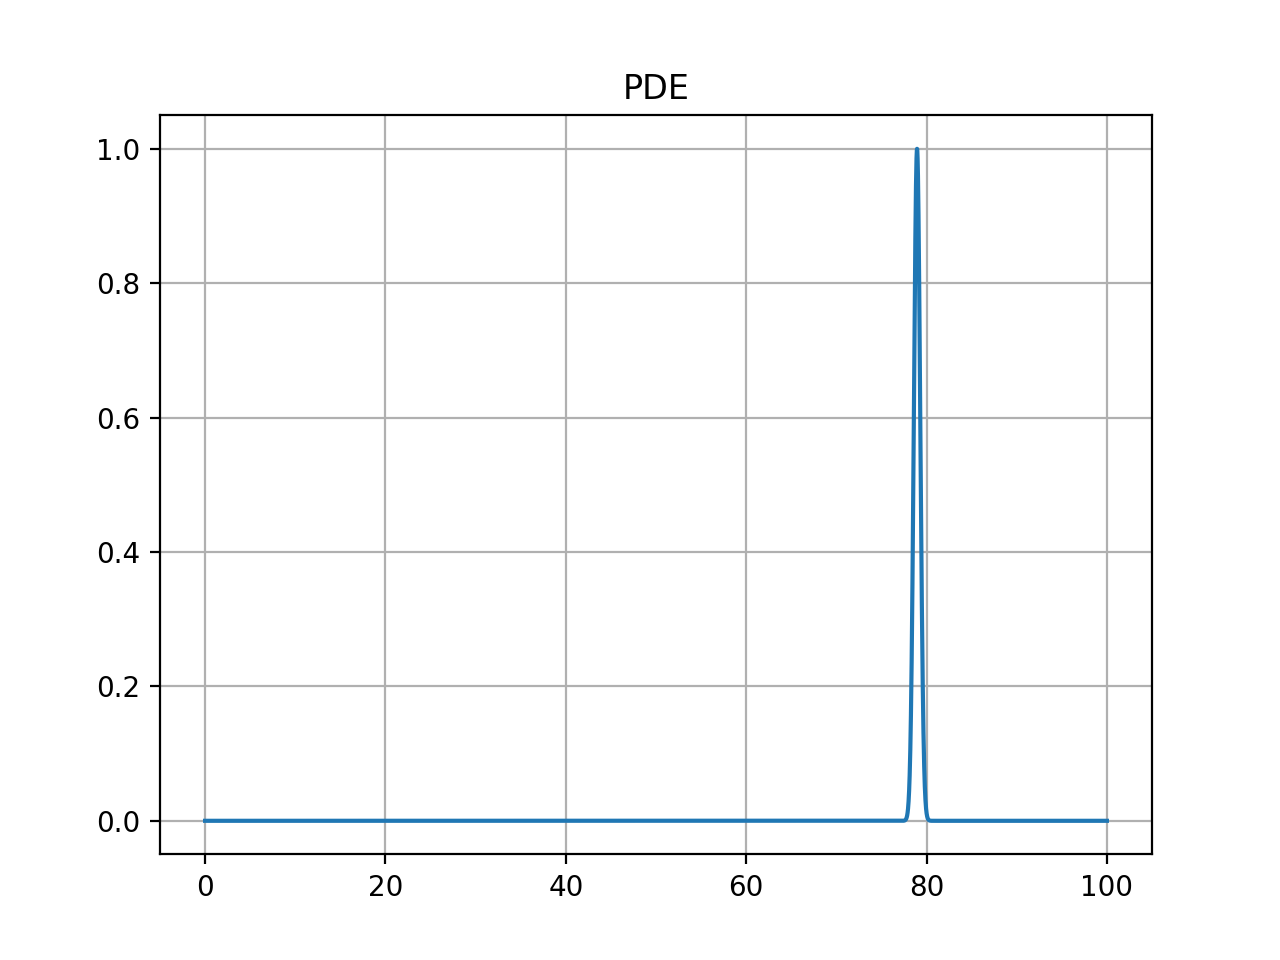

<IPython.core.display.Javascript object>


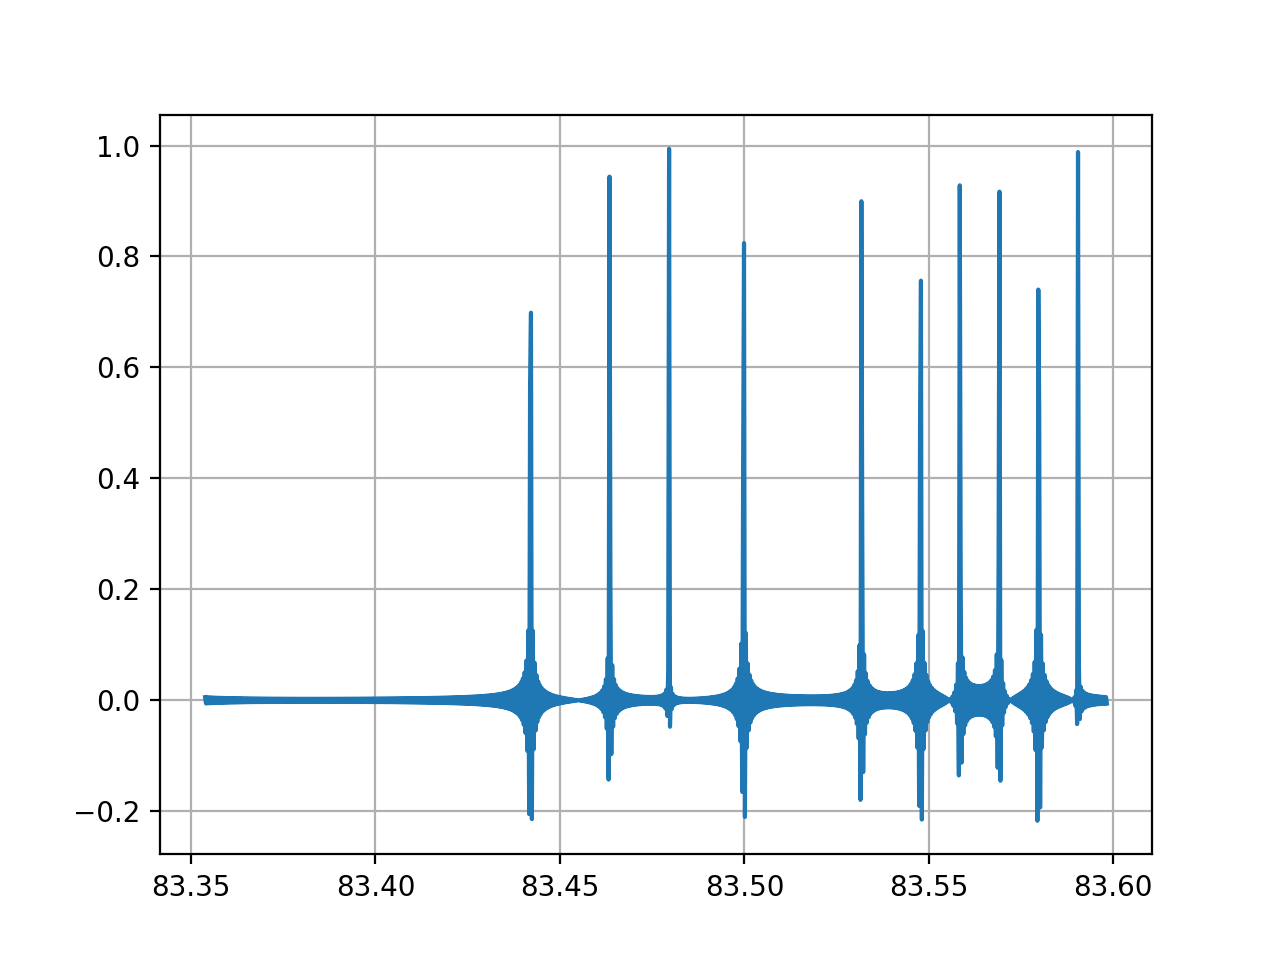

In [6]:
%matplotlib notebook

"""Target in this cell is to sample energies according to an energy distribution with the change in central energy.
Also get the time waveforms."""

from buildwaveforms import energy2time,e_mc2
import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt

L = 3.75+5.0+35.0
m = e_mc2
E0i = 0  #eV
E0f = 100 #eV
delta_E0i = 1.0e-4 #ev
delta_E0f = 0.4 #eV
N_E0_sam = 20  # no. of distributions with different E0s(central energies)

E0 = np.linspace(E0i,E0f,N_E0_sam)
delta_E = ((delta_E0f-delta_E0i)/E0f**2)*E0**2  # ~quadratic fit(may be a source of numerical error)

#define the energy axis and energy distribution
Ei = 0  #eV
Ef = 100 #eV
N_E_pts = 10000
E = np.linspace(Ei,Ef,N_E_pts)
E_dist = np.exp(-(E-E0[15])**2/delta_E[15])

N_E_sam = 10
E_rand = sample_distribution(E,E_dist,N=N_E_sam)
time_TOA = energy2time(E_rand)

timeaxis = np.linspace(min(time_TOA)-0.01,max(time_TOA)+0.01,1000) 
freq = fftfreq(timeaxis.size,d=timeaxis[1]-timeaxis[0])

s = np.real(ifft(np.sum(np.exp(-2*np.pi*1j*freq*time_TOA),axis=0)))
#print time_TOA

fig = plt.figure()
plt.plot(timeaxis,s)
plt.grid(True)

In [5]:
%matplotlib notebook

from scipy.signal import hilbert
from scipy import sparse
import time

thr = []
frac =0.05
havg_im = np.imag(hilbert(havg))
snr = np.abs(havg)**2+np.abs(havg_im)**2
for i in range(havg.size):
    thr.append(frac*max(snr))

havg_mod = np.zeros(havg.size)
for i in range(havg.size):
    if snr[i]>=thr[0]:
        havg_mod[i] = havg[i]
fig = plt.figure()
plt.plot(timeaxis,havg,label='Real havg')
plt.plot(timeaxis,havg_im,label='Imag havg')
plt.grid(True)
plt.legend()

fig = plt.figure()
plt.plot(timeaxis,snr,label='~SNR')
plt.plot(timeaxis,thr,label='threshold(%i%%)'%(frac*100))
plt.plot(timeaxis,havg,label='Real havg')
plt.plot(timeaxis,havg_mod,label='Modified havg')
plt.grid(True)
plt.legend()

#count number of non-zero, havg_mod entries
"""nz_count = 0
for i in range(havg_mod.size):
    if havg_mod[i]!=0:
        nz_count += 1
print nz_count"""

#generate sparse convolution matrix
start = time.time()

hsparse = generate_sparse_convolmatrix(havg_mod)
s_cpy = sparse.lil_matrix((1,s.size))
s_cpy[:] = s[:]
y_mod = (hsparse.tocsr()*s_cpy.tocsr().transpose())

end = time.time()
print 'Time elapsed= %i ms'%((end - start)*1000)

fig = plt.figure()
plt.plot(timeaxis,s,label='Input Signal')
plt.plot(timeaxis,y,label='Complete Output')
plt.plot(timeaxis,y_mod.todense(),label='Sparse Output')
plt.grid(True)
plt.legend()

NameError: name 'havg' is not defined